# Product Forecasting

Work Flow

- Import Data and Libaries
- Data Exploring and Preprocessing
- Data Visualization
- Feature Engineering
- Explore the Dataset and visualize data
- Model Build & Validation: ARIMA/SARIMA/LSTM
- Forecast
- Conclusion

data source: https://www.kaggle.com/datasets/felixzhao/productdemandforecasting/code


## Set up

In [1]:
# Mount google driver
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/MyDrive/Colab Notebooks"

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks


In [2]:
# Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import statistics
import math

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

color_pal = sns.color_palette()
plt.style.use('ggplot')

In [3]:
# Import the data and parse dates
df  = pd.read_csv('Demand Forecast Project/dataset/time_series/Historical_Product_Demand.csv', parse_dates=['Date'])

## Data exploring and preprocessing

In [4]:
# Getting the first 10 rows to view the records
df.head(10)

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012-07-27,100
1,Product_0979,Whse_J,Category_028,2012-01-19,500
2,Product_0979,Whse_J,Category_028,2012-02-03,500
3,Product_0979,Whse_J,Category_028,2012-02-09,500
4,Product_0979,Whse_J,Category_028,2012-03-02,500
5,Product_0979,Whse_J,Category_028,2012-04-19,500
6,Product_0979,Whse_J,Category_028,2012-06-05,500
7,Product_0979,Whse_J,Category_028,2012-06-27,500
8,Product_0979,Whse_J,Category_028,2012-07-23,500
9,Product_0979,Whse_J,Category_028,2012-08-29,500


In [5]:
# Check the cardinality
print("The shape of dataset:", df.shape)
# Check the data types
print("\nDatatype of each column:")
print(df.dtypes)


The shape of dataset: (1048575, 5)

Datatype of each column:
Product_Code                object
Warehouse                   object
Product_Category            object
Date                datetime64[ns]
Order_Demand                object
dtype: object


In [6]:
# get an overview of dataset
df.describe()

<ipython-input-6-ce510b7bc70f>:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df.describe()


,Product_Code,Warehouse,Product_Category,Date,Order_Demand
count,1048575,1048575,1048575,1037336,1048575
unique,2160,4,33,1729,3828
top,Product_1359,Whse_J,Category_019,2013-09-27 00:00:00,1000
freq,16936,764447,481099,2075,112682
first,NaN,NaN,NaN,2011-01-08 00:00:00,NaN
last,NaN,NaN,NaN,2017-01-09 00:00:00,NaN


In [7]:
# Check the demand
df.sort_values('Date')[10:20]

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
75193,Product_0642,Whse_C,Category_019,2011-10-31,3
121820,Product_0202,Whse_A,Category_007,2011-11-04,(100)
121819,Product_0202,Whse_A,Category_007,2011-11-04,(400)
131028,Product_2143,Whse_S,Category_009,2011-11-18,(25)
131031,Product_0131,Whse_S,Category_021,2011-11-18,(12)
131032,Product_0288,Whse_S,Category_021,2011-11-18,(50)
44450,Product_0980,Whse_A,Category_028,2011-11-18,4000
131027,Product_2138,Whse_S,Category_009,2011-11-18,(49)
131026,Product_2137,Whse_S,Category_009,2011-11-18,(25)
44795,Product_0965,Whse_A,Category_006,2011-11-18,1


### Change the negative values to 0

In [8]:
# Convert the Order_demand to an Integer
# If the demand is negative, change it to 0
def change_to_int(x):
    try:
        return int(x)
    except:
        return 0

df.Order_Demand = df.Order_Demand.apply(lambda x: change_to_int(x))

In [9]:
df.describe()

,Order_Demand
count,1.048575e+06
mean,4.887202e+03
std,2.888354e+04
min,0.000000e+00
25%,1.800000e+01
50%,3.000000e+02
75%,2.000000e+03
max,4.000000e+06


In [10]:
# Check the data types again
print("Datatype of each column:")
print(df.dtypes)

Datatype of each column:
Product_Code                object
Warehouse                   object
Product_Category            object
Date                datetime64[ns]
Order_Demand                 int64
dtype: object


### Remove rows with NaN

In [11]:
# Check any number of columns with NaN
print("Number of columns with NaN:", df.isnull().any().sum())
# Check any number of data points with NaN
print("Number of data points with NaN: ", df.isnull().any(axis=1).sum())


Number of columns with NaN: 1
Number of data points with NaN:  11239


In [12]:
# Lets check where these nulls are.
print (df.isna().sum())
print ('Null to Dataset Ratio in Dates: ',df.isnull().sum()[3]/df.shape[0]*100)
#There are missing values in Dates.

Product_Code            0
Warehouse               0
Product_Category        0
Date                11239
Order_Demand            0
dtype: int64
Null to Dataset Ratio in Dates:  1.0718355863910547


In [13]:
# Drop na's.

#Since the number of missing values are about 1%, I am taking an 'executive decision' of removing them. ;)
df.dropna(axis=0, inplace=True) #remove all rows with na's.
df = df.set_index('Date')
df.index = pd.to_datetime(df.index)
df.sort_values('Date')[10:20] #Some of the values have () in them.

,Product_Code,Warehouse,Product_Category,Order_Demand
Date,,,,
2011-10-31,Product_0642,Whse_C,Category_019,3
2011-11-04,Product_0202,Whse_A,Category_007,0
2011-11-04,Product_0202,Whse_A,Category_007,0
2011-11-18,Product_2143,Whse_S,Category_009,0
2011-11-18,Product_0131,Whse_S,Category_021,0
2011-11-18,Product_0288,Whse_S,Category_021,0
2011-11-18,Product_0980,Whse_A,Category_028,4000
2011-11-18,Product_2138,Whse_S,Category_009,0
2011-11-18,Product_2137,Whse_S,Category_009,0


## Data Visualization

Text(0.5, 1.0, 'The count of orders by warehouses')

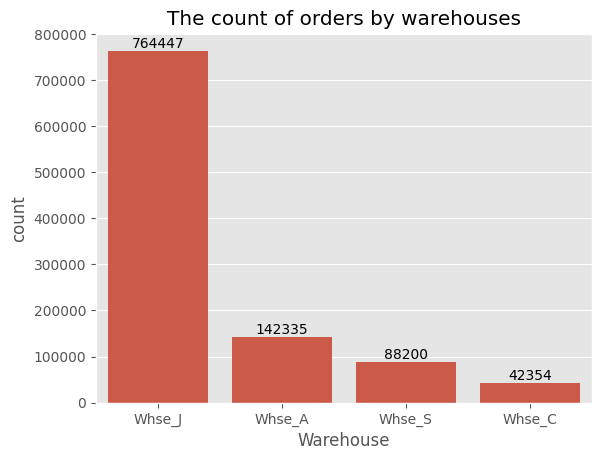

In [14]:
# Find the aggregate demand among the warehouses
count = sns.countplot(x=df['Warehouse'],
                   order=df['Warehouse'].value_counts(ascending=False).index)

abs_values = df['Warehouse'].value_counts(ascending=False).values

count.bar_label(container=count.containers[0], labels=abs_values)
count.set_title("The count of orders by warehouses")

Warehouses Whse_J has significantly more orders than the other warehouses followed by Whse_A, then Whse_S and Whse_C.

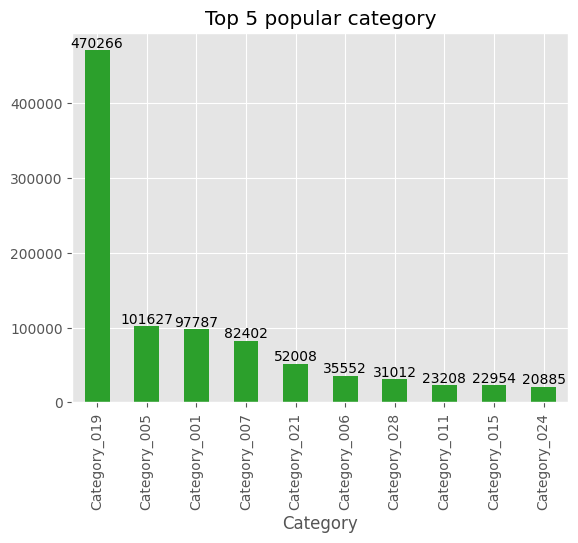

In [15]:
# Plot the 5 most popular category
top10 = df.Product_Category.value_counts().head(10).plot(kind = 'bar', color = color_pal[2])
top10.bar_label(top10.containers[0])
top10.set_title("Top 5 popular category")
plt.xlabel('Category')
plt.show()

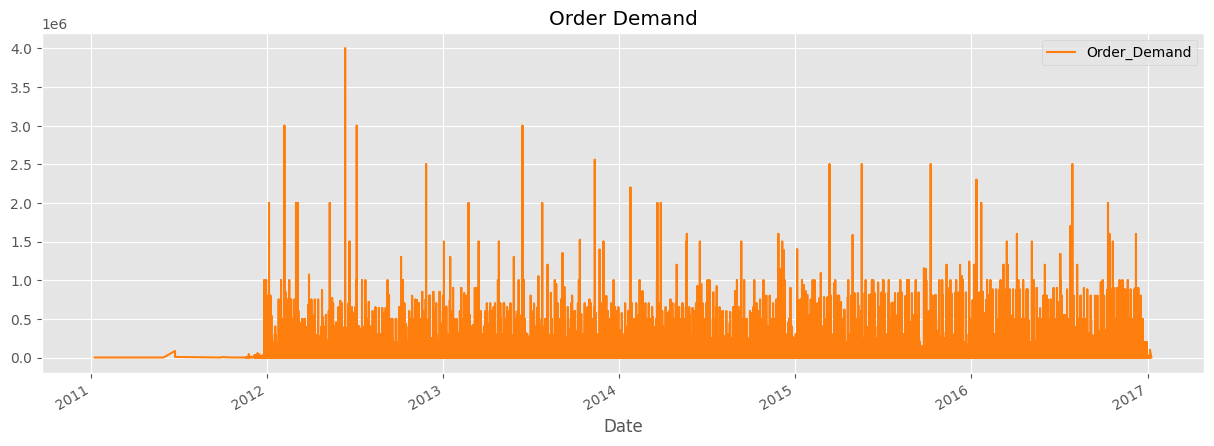

In [16]:
# Find the distribution of the demand
df.plot(kind = 'line',figsize=(15, 5),color = color_pal[1], title = 'Order Demand' )
plt.show()

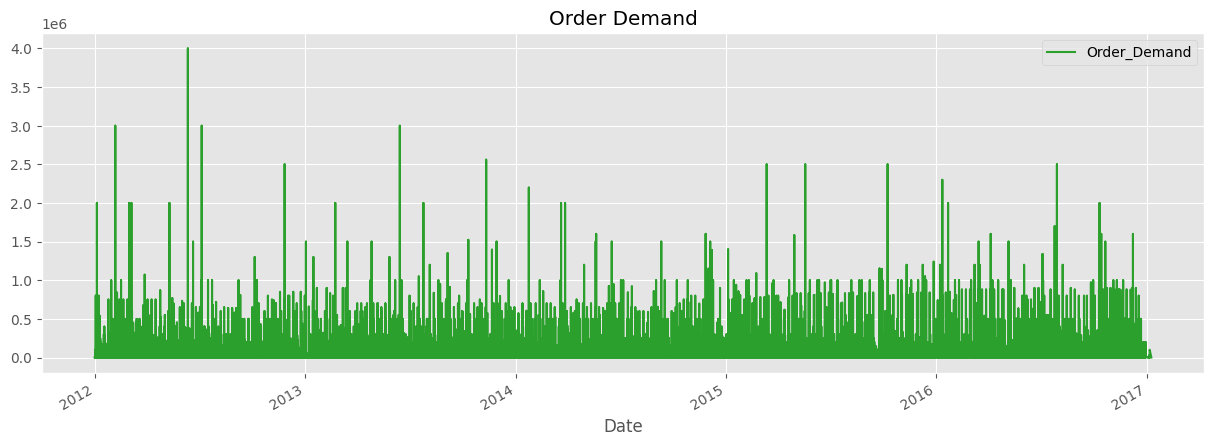

In [17]:
# Delete data before 2012-01-01
df_new = df.loc[df.index >= '01-01-2012']
df_new.plot(kind = 'line',figsize=(15, 5),color = color_pal[2], title = 'Order Demand' )
plt.show()

## Feature Engineering

This dataset have a lot of missing data before 1st January 2012. For accurate demand, the data befre 1st January 2012 is deleted.

In [18]:
# Function that create time series features using the index columns
def create_feature(dataframe):
    dataframe = dataframe.copy()
    dataframe['day_of_the_week'] = dataframe.index.dayofweek
    dataframe['Quarter'] = dataframe.index.quarter
    dataframe['Month'] = dataframe.index.month
    dataframe['Year'] = dataframe.index.year
    dataframe['Week'] = dataframe.index.isocalendar().week.astype(int)
    return dataframe

df = create_feature(df_new)
df.dtypes

Product_Code        object
Warehouse           object
Product_Category    object
Order_Demand         int64
day_of_the_week      int64
Quarter              int64
Month                int64
Year                 int64
Week                 int64
dtype: object

In [19]:
df.head(5)

,Product_Code,Warehouse,Product_Category,Order_Demand,day_of_the_week,Quarter,Month,Year,Week
Date,,,,,,,,,
2012-07-27,Product_0993,Whse_J,Category_028,100,4,3,7,2012,30
2012-01-19,Product_0979,Whse_J,Category_028,500,3,1,1,2012,3
2012-02-03,Product_0979,Whse_J,Category_028,500,4,1,2,2012,5
2012-02-09,Product_0979,Whse_J,Category_028,500,3,1,2,2012,6
2012-03-02,Product_0979,Whse_J,Category_028,500,4,1,3,2012,9


## Model Build & Validation

### Model Preparation

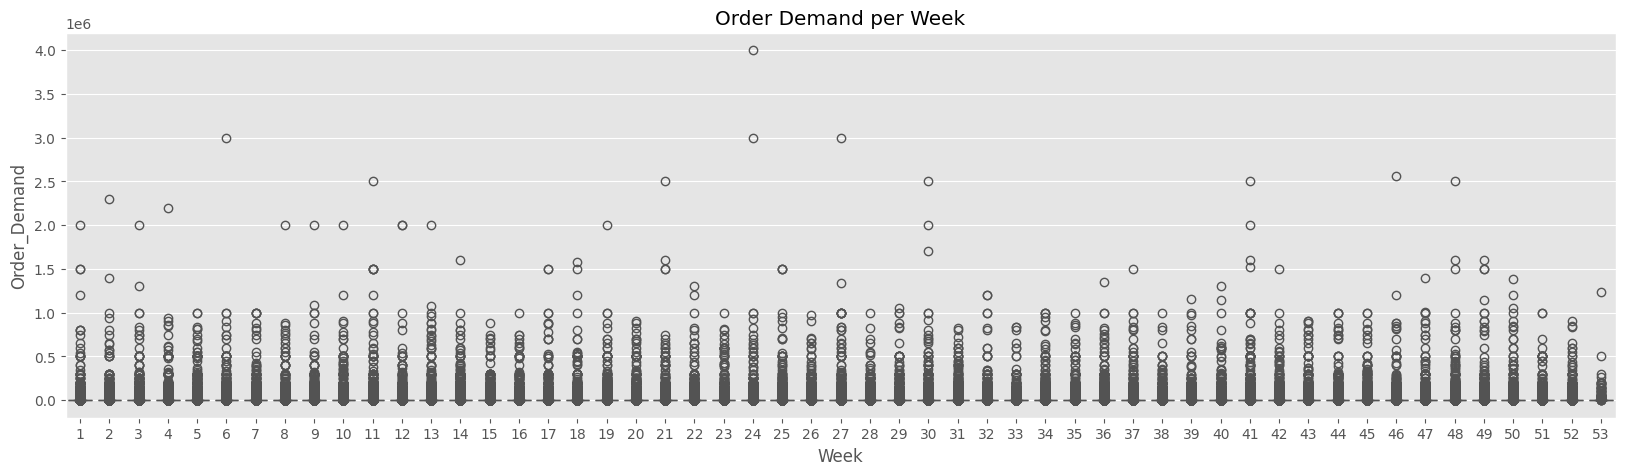

In [20]:
# Visualise Features
fig, ax = plt.subplots(figsize=(20, 5))
sns.boxplot(data=df, x='Week', y='Order_Demand')
ax.set_title('Order Demand per Week')
plt.show()

In this data, there are lots of same data values. So, I will collect them together as weekly.

<ipython-input-21-4412280d7e56>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_week = df.resample('W').mean()


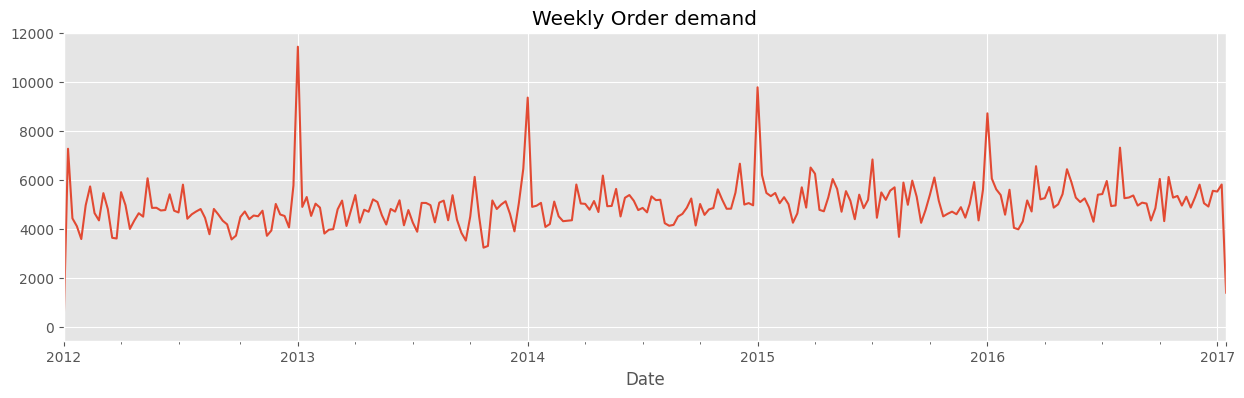

In [21]:
# Resample data as Weekly
df_week = df.resample('W').mean()
df_week['Order_Demand'].plot(figsize = (15,4), title = 'Weekly Order demand')
plt.show()

- These data show a seasonal pattern.
- The pattern repeats every 12 months.
- The demand increase in December (probably due to the holiday season) and decrease probably in January.
- Try to explore the monthly pattern by sampling the data monthly

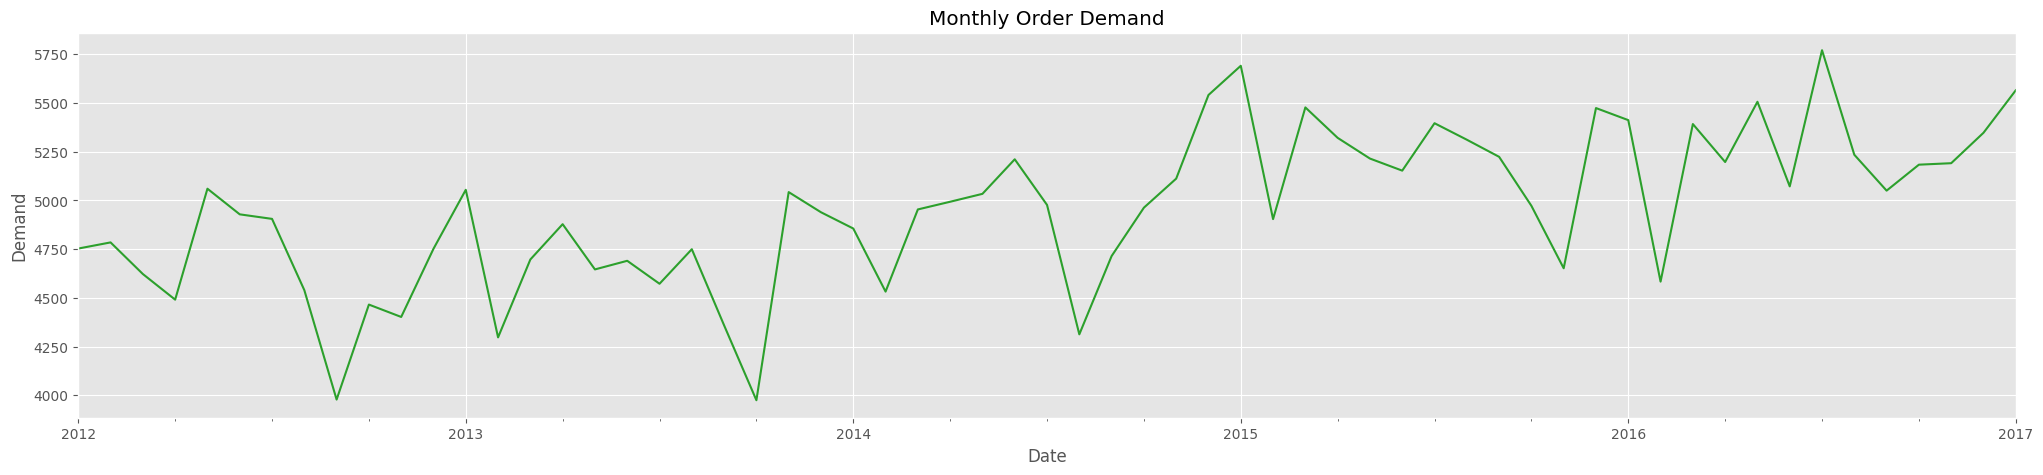

In [22]:
# Explore the monthly pattern
df_month = df['Order_Demand'].resample('MS').mean()
df_month.plot(figsize = (25,5), title = 'Monthly Order Demand', color = color_pal[2])
plt.ylabel('Demand')
plt.show()

This plot shows a clear upward trend from the last quarter of 2013 to the beginning of 2017.

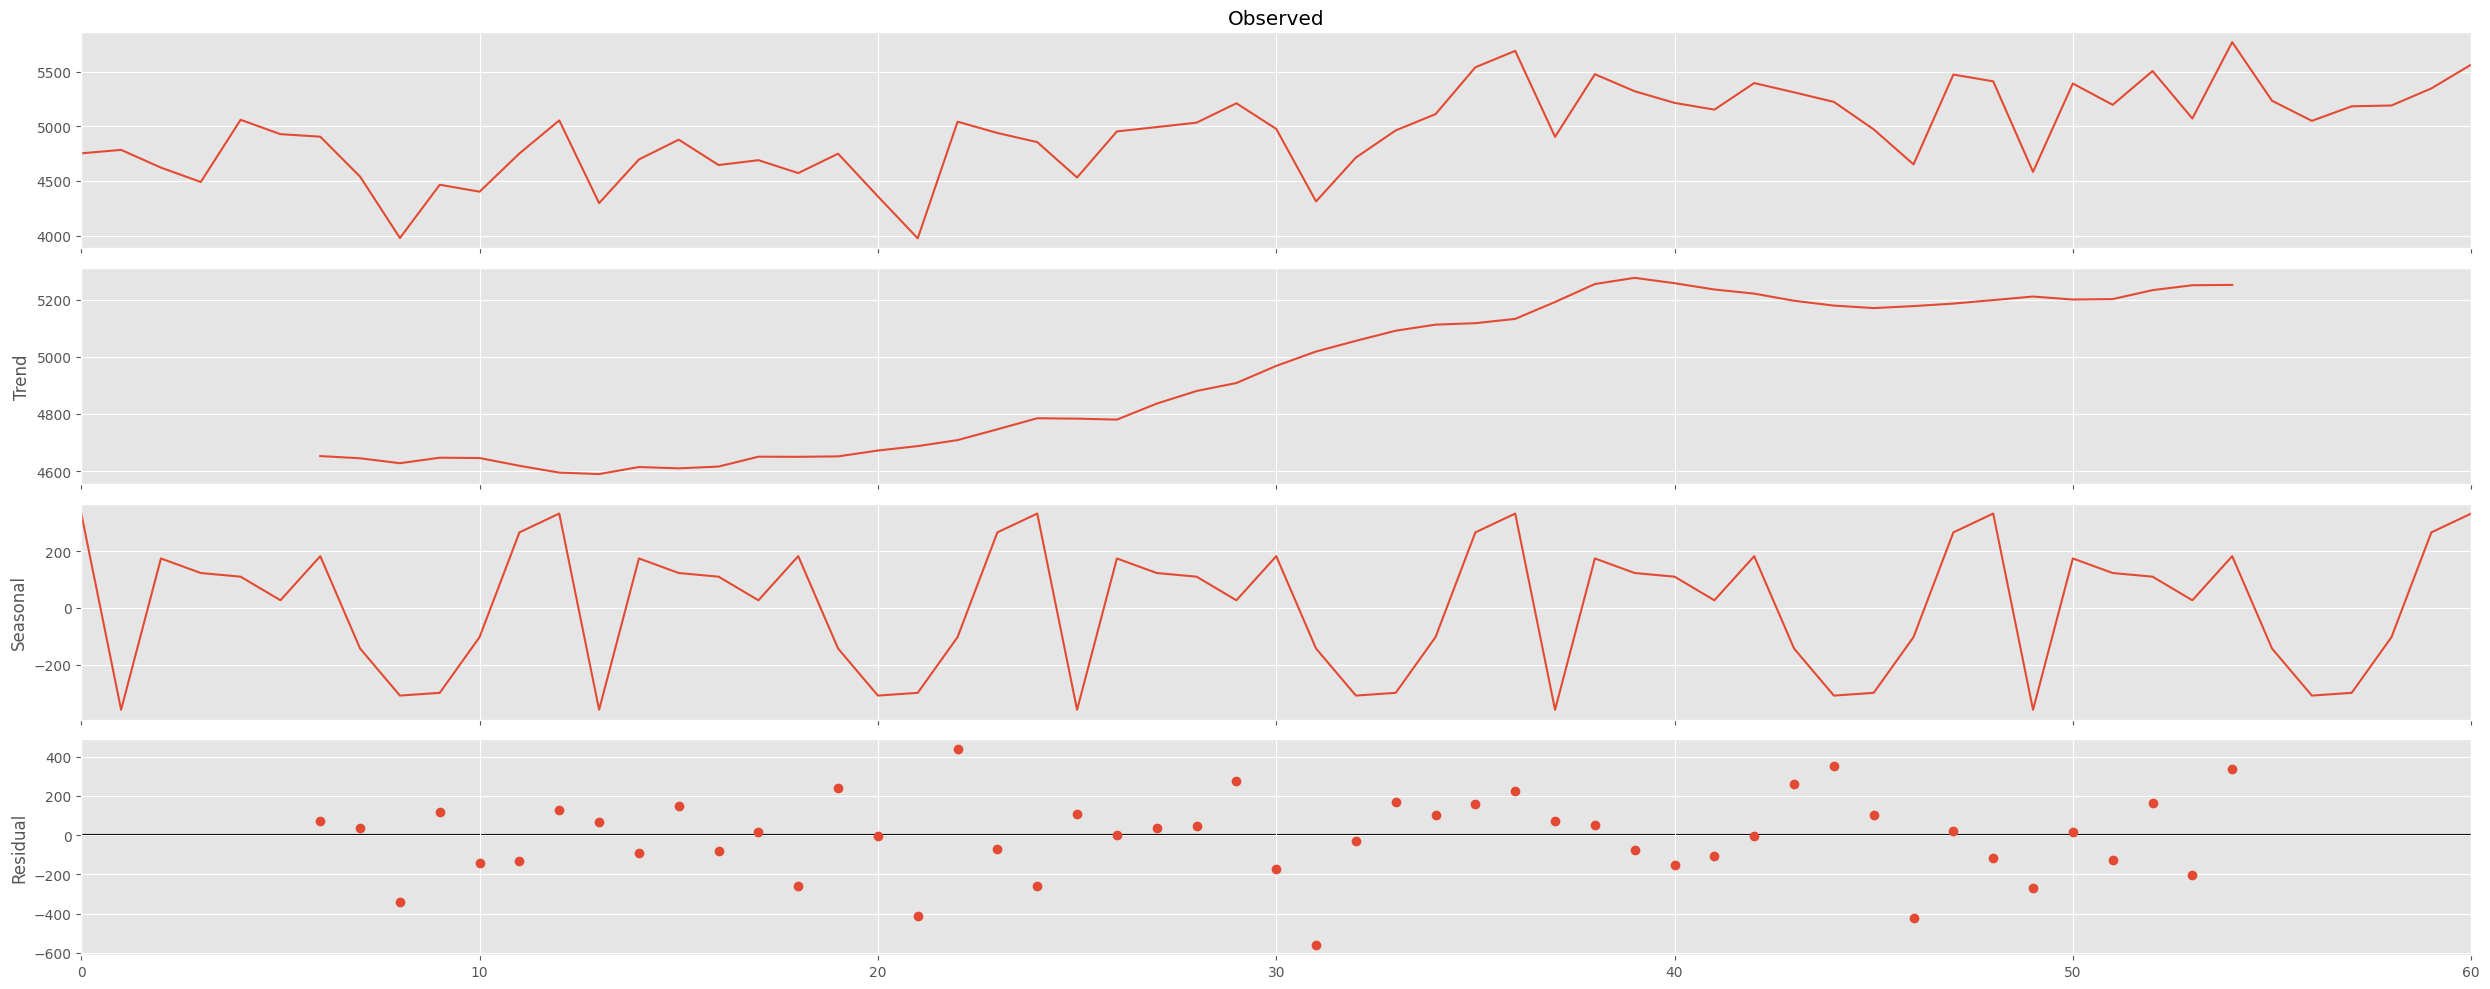

In [23]:
# Decompose the dataset
# Seasonal decomposition using moving averages
from pylab import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose
rcParams['figure.figsize'] = 25, 10
decomposition = seasonal_decompose(df_month.values, model='additive', period = 12)

fig = decomposition.plot()
plt.show()

Visually, the time series is non-stationary

In [24]:
# Perform the Augmented Dickey- Fuller test (ADF) to check
from statsmodels.tsa.stattools import adfuller
adfuller(df_month)

(-2.1370166747378168,
 0.2298927739226595,
 2,
 58,
 {'1%': -3.548493559596539,
  '5%': -2.912836594776334,
  '10%': -2.594129155766944},
 714.7752778543951)

- p-value > 0.05 (null hypothesis: unit root)
- The time series is non-stationary

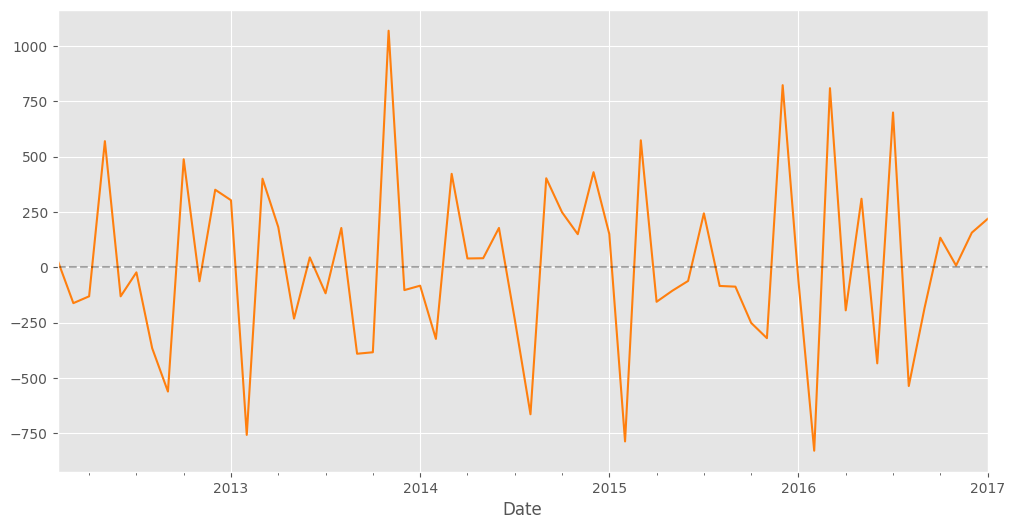

In [25]:
# Make series stationnary
# Take First Difference to Remove Trend
df_diff = df_month.diff()[1:]
df_diff.plot(figsize=(12,6), color = color_pal[1])
plt.axhline(0, linestyle='--', color='k', alpha=0.3)

In [26]:
# Augmented Dicker Fuller Test to check if this new series is stationnary after differentiation
adfuller(df_diff)

(-6.7674876482368855,
 2.693959530513771e-09,
 2,
 57,
 {'1%': -3.5506699942762414,
  '5%': -2.913766394626147,
  '10%': -2.5946240473991997},
 700.9674125537764)

- p-value < 0.05  (reject null hypothesis: stationnary)

### Train / Test split

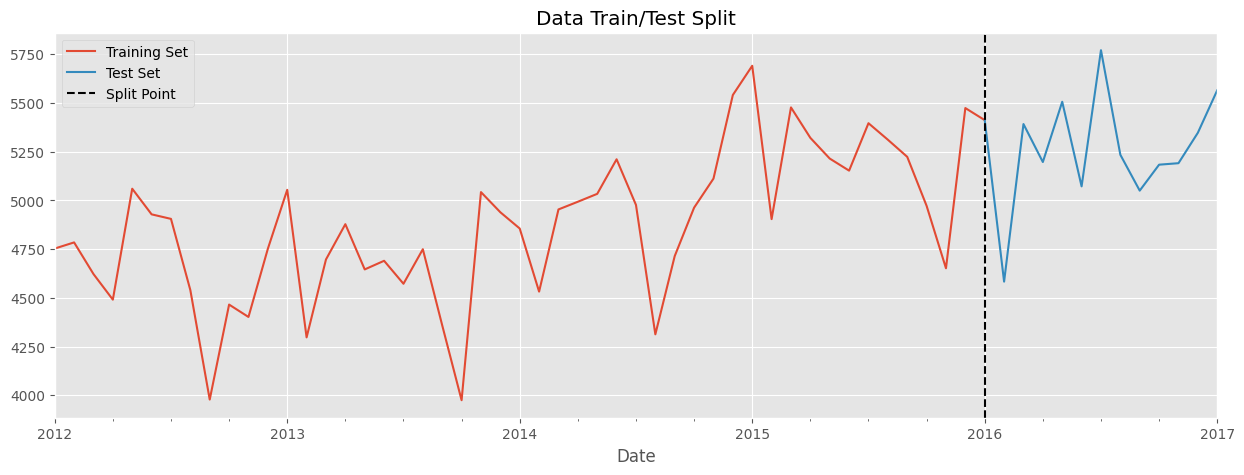

In [27]:
from datetime import datetime
from datetime import timedelta
train_end = datetime(2016,1,1)
test_end = datetime(2017,1,1)

df_train = df_month[:train_end]
df_test = df_month[train_end:test_end]

# plot train and test dataset on the same graph
fig, ax = plt.subplots(figsize=(15, 5))
df_train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
df_test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2016', color='black', ls='--')
ax.legend(['Training Set', 'Test Set','Split Point'])
plt.show()

### Build ARIMA Model

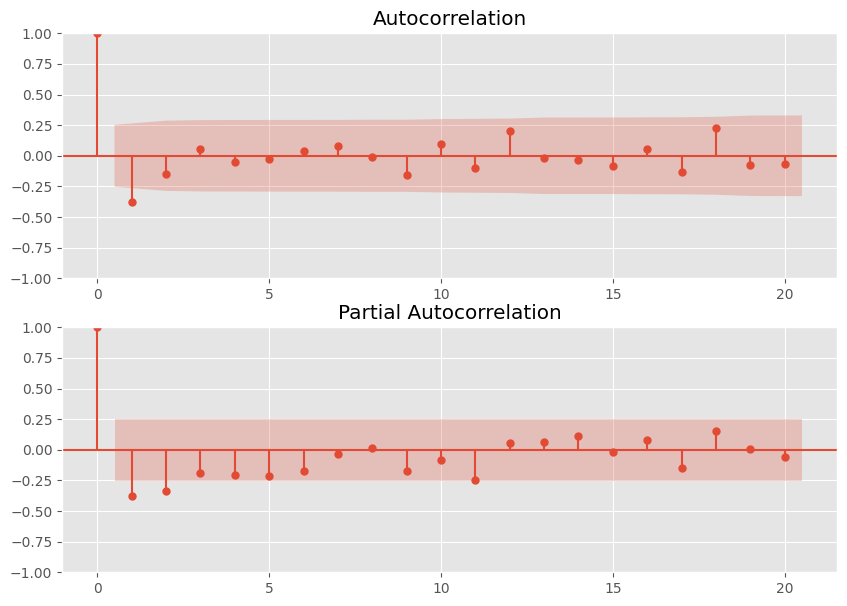

In [43]:
# ARIMA (p,d,q) => using ACF And PCAF plots to find p,q
# d is the degree of differencing => 1

# Import libraries
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# plot ACF
fig = plt.figure(figsize = (10,7))
ax1 = fig.add_subplot(211)
fig = plot_acf(df_diff, lags = 20, ax = ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(df_diff, lags = 20, method='ywm', ax = ax2)
plt.show()

- Based on the AutoCorrelation chart, Lag 1 is strong => the order of q is 1
- Based on the Partial AutoCorrelation chart, Lag 1 and 2 are strong => the order of p is 2

In [44]:
# Fit the model
from statsmodels.tsa.arima.model import ARIMA
model_arima = ARIMA(df_train, order = (2,1,1)).fit()
print(model_arima.summary())

                               SARIMAX Results                                
Dep. Variable:           Order_Demand   No. Observations:                   49
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -344.918
Date:                Tue, 13 Feb 2024   AIC                            697.837
Time:                        15:37:52   BIC                            705.322
Sample:                    01-01-2012   HQIC                           700.665
                         - 01-01-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2398      0.177      1.358      0.175      -0.106       0.586
ar.L2         -0.1673      0.273     -0.613      0.540      -0.702       0.368
ma.L1         -0.7929      0.207     -3.822      0.0

### Validate ARIMA Model

In [45]:
# Get the predictions start and end dates
pred_start = df_test.index[0]
pred_end= df_test.index[-1]

# Make predictions
pred_arima = model_arima.predict(start = pred_start, end = pred_end)

# Get the residuals
residuals_arima = df_test - pred_arima

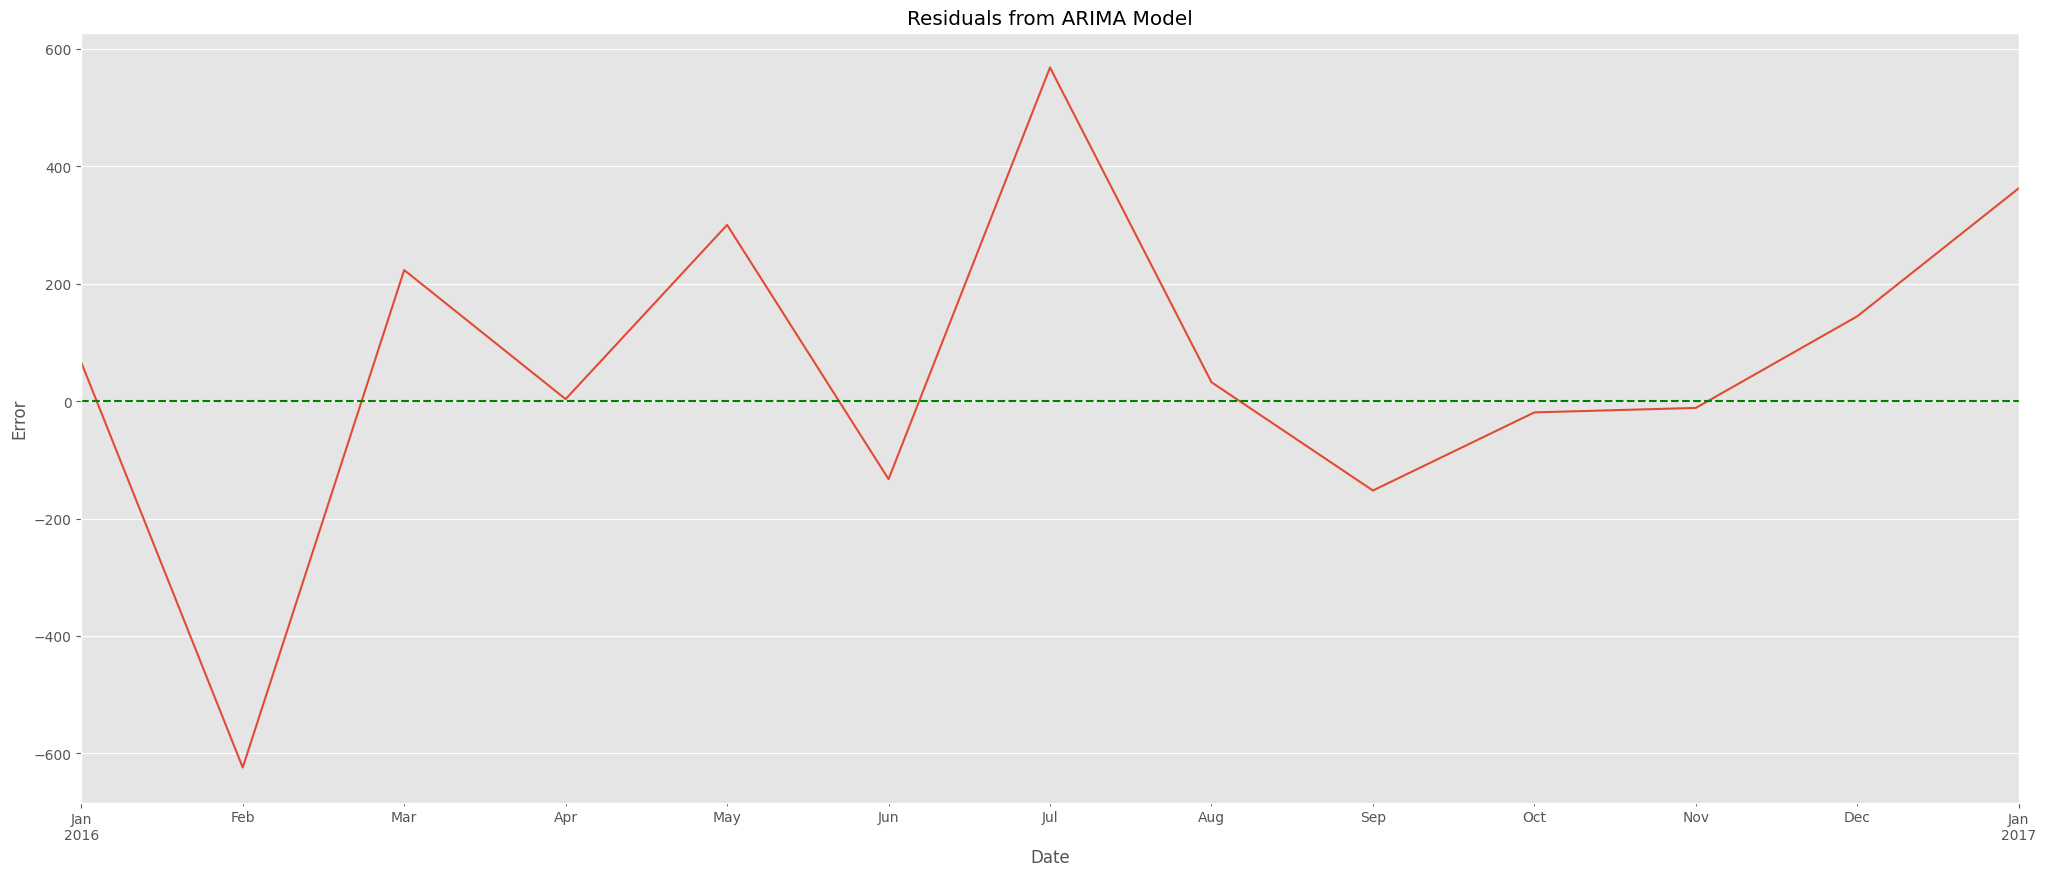

In [46]:
# Plot the residuals
residuals_arima.plot(kind = 'line', title = 'Residuals from ARIMA Model')
plt.axhline(0,color ='g', linestyle = '--')
plt.ylabel('Error')
plt.show()

In [47]:
# Get the Root Mean Square Error
rmse_arima = np.sqrt(np.mean(residuals_arima**2))
print("ARIMA RMSE:", rmse_arima)

ARIMA RMSE: 284.4672453594125


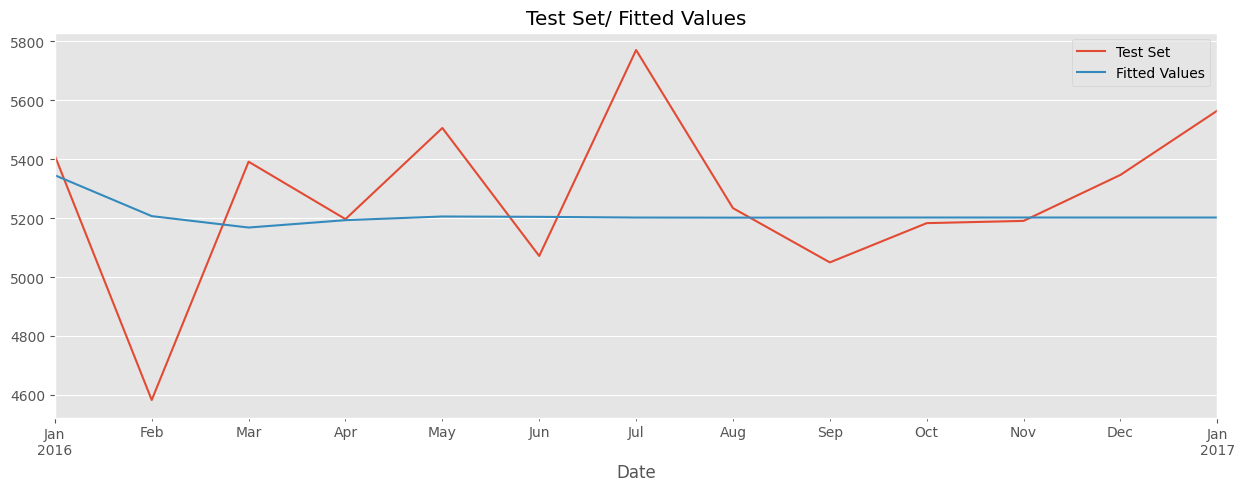

In [48]:
# Plot the train set against the predicted values
fig, ax = plt.subplots(figsize=(15, 5))
df_test.plot(ax=ax, label='Training Set', title='Test Set/ Fitted Values')
pred_arima.plot(ax=ax, label='Prediction')
ax.legend(['Test Set', 'Fitted Values'])
plt.show()

### Build SARIMA Model

In [49]:
# Import libraries
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools

# GRID SEARCH for Param Tuning
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [50]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            model_sarima  = SARIMAX(df_train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = model_sarima.fit()

            print('SARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

SARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:953.8334562619704
SARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:675.2585690131693
SARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:542.6203641912743
SARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1106.9787543138743
SARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:553.1081325115795
SARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:526.3362099107103
SARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:380.9229715254302
SARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:365.8221209820799
SARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:903.038376915668


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:639.3459152789402
SARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:524.1917232461125


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1051.3862424009026
SARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:553.0963261020297


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:514.3165794412844
SARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:370.6087208048527
SARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:344.18682178185645
SARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:693.7790979703183
SARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1412.5480057028487
SARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:536.8515982568387


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:341.2826732433041
SARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:535.620012329948


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:1218.181095768552
SARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:355.89003044439994
SARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:343.1962040702358
SARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:669.3164914333953


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:1296.6204641215088
SARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:508.871094869595
SARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:322.47159787674826
SARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:525.9601837442696


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:1589.725040928202
SARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:351.38006162925683
SARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:322.29877990815567
SARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:709.4941737001695
SARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:536.8360243478857
SARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:540.6509036888717


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:1030.3222050595355
SARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:540.0603035080674
SARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:528.2878538884673
SARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:354.0104023540076
SARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:355.5165517278758
SARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:684.5461689230059
SARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:510.79574179453357
SARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:524.5600384536008


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:1007.231525995966
SARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:526.6926651503129
SARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:512.3832110968112
SARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:354.587976803386


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:336.2685245082606
SARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:691.7130025344908


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:1072.4293828461712
SARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:533.8121889371888
SARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:342.11432696745396
SARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:515.9529298126245


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:1378.0023032523675
SARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:341.56569657133866
SARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:343.18635314532736
SARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:669.5530135873436
SARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:2599.5403856743055
SARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:510.4997264898549


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:324.0539831260556
SARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:508.9299149320051


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:1963.4046839828416
SARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:337.1272213910853


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:323.9341903658399


In [51]:
# Fit the model with the best params.
# SARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:322.29877990815567
# SARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:324.0539831260556 # 226
# SARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:322.47159787674826 # 223
model_sarima =SARIMAX(df_train,
                                order=(0, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False).fit()
print(model_sarima.summary().tables[1])


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7208      0.248     -2.911      0.004      -1.206      -0.236
ma.S.L12      -0.9942     28.080     -0.035      0.972     -56.029      54.041
sigma2       7.38e+04   2.06e+06      0.036      0.971   -3.97e+06    4.12e+06


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


### Validate SARIMA Model

In [52]:
pred_sarima = model_sarima.predict(start = pred_start, end = pred_end)

In [53]:
# Get the residuals
residuals_sarima = df_test - pred_sarima

# Get the Root Mean Square Error
rmse_sarima = np.sqrt(np.mean(residuals_sarima**2))
print("SARIMA RMSE:", rmse_sarima)

SARIMA RMSE: 223.8973002558601


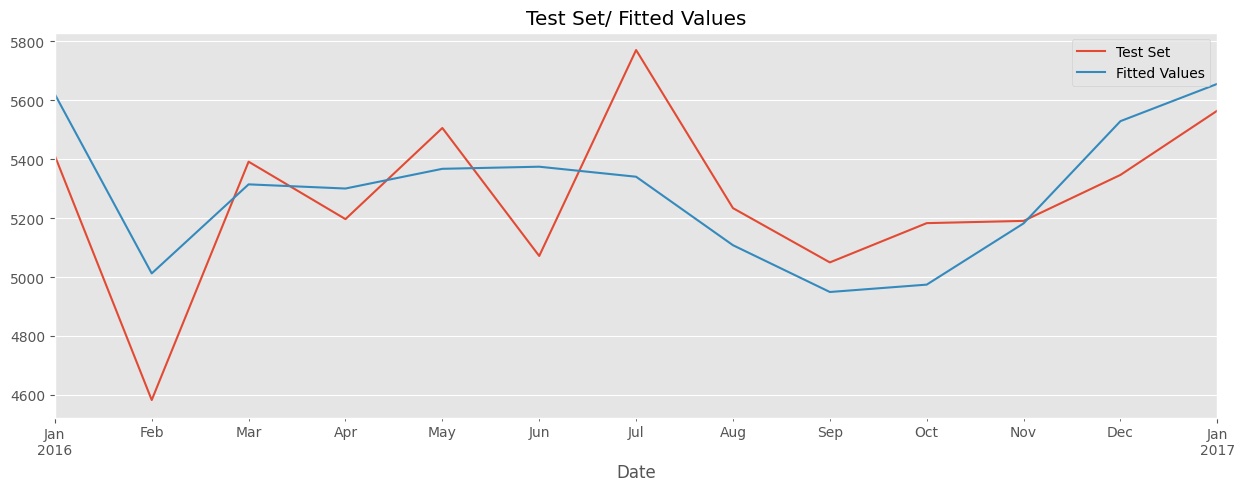

In [54]:
fig, ax = plt.subplots(figsize=(15, 5))
df_test.plot(ax=ax, label='Training Set', title='Test Set/ Fitted Values')
pred_sarima.plot(ax=ax, label='Prediction')
ax.legend(['Test Set', 'Fitted Values'])
plt.show()

## Forecast

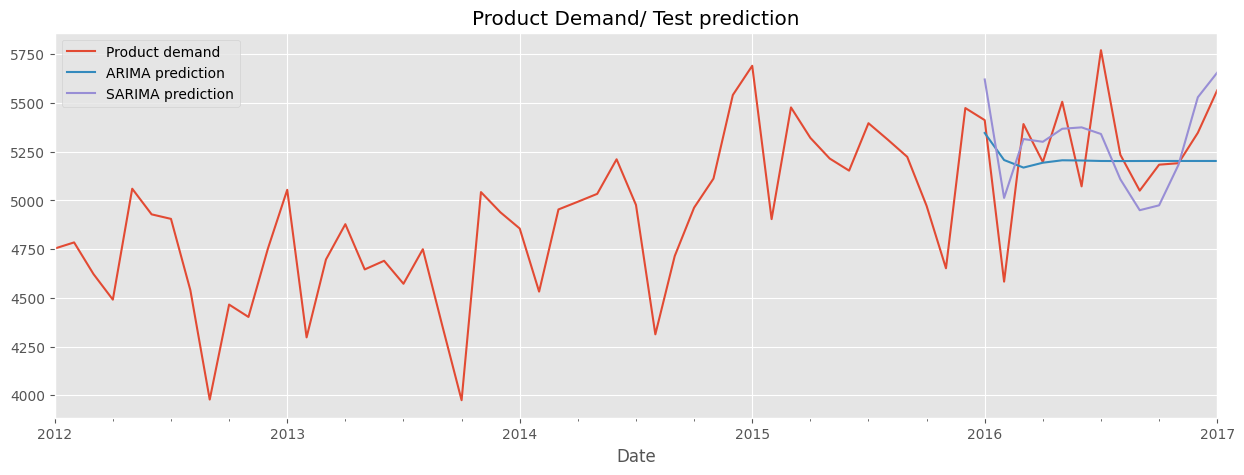

In [55]:
# Plot the actual data set and the actual predicted values
fig, ax = plt.subplots(figsize=(15, 5))
df_month.plot(ax=ax, label='Product Demand', title='Product Demand/ Test prediction')
pred_arima.plot(ax=ax, label='ARIMA prediction')
pred_sarima.plot(ax=ax, label='SARIMA prediction')
ax.legend(['Product demand', 'ARIMA prediction', 'SARIMA prediction'],)
plt.show()

In [56]:
residuals = pd.concat([residuals_arima,residuals_sarima], axis = 1, ignore_index= False)
residuals.columns = ['ARIMA', 'SARIMA']

ARIMA RMSE: 284.4672453594125
SARIMA RMSE: 223.8973002558601


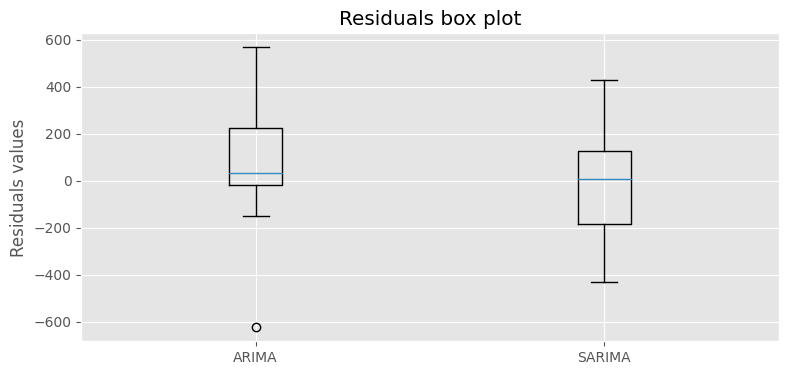

In [57]:
# Visualize the rmse
fig, ax1 = plt.subplots(figsize=(9, 4))
# residuals_sarima_d.boxplot()
ax1.boxplot(residuals,
                    #  vert=True,  # vertical box alignment
                    #  patch_artist=True,  # fill with color
                     meanline = True,
                     labels=['ARIMA', 'SARIMA'])  # will be used to label x-ticks
ax1.set_title('Residuals box plot')
ax1.set_ylabel('Residuals values')
print("ARIMA RMSE:", rmse_arima)
print("SARIMA RMSE:", rmse_sarima)

In [58]:
# Import pickle
import pickle
# save the model to disk
filename = 'Demand Forecast Project/sarima_model.sav'
pickle.dump(model_sarima, open(filename, 'wb'))

# Conclusion

- **Data Integrity**: Due to the presence of unreasonable values (negative values) in the raw data, it may affect the accuracy of the predictions.
- **Forecasting by Each Item**: Limited by computational resources, the current predictions are based on forecasts for all items. However, if it were possible to forecast the demand for each item separately and then aggregate them, the predictions might be more accurate.
- **Other Model or Parameters**: Other models could be explored, such as LSTM, or considering qualitative parameters for prediction, such as economic indices, holidays, or market competitors.